# `Particle` in an East Greenland regional simulation

Author: Wenrui Jiang, Tom Haine Feb '23

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import oceanspy as ospy

import seaduck as sd

```{admonition} Access IGP
The regional MITgcm run is the IGPwinter simulation and is publicly available on [SciServer](sciserver.org) (from the Oceanography container). The simulation output can be opened using the [OceanSpy](https://github.com/hainegroup/oceanspyhttps://github.com/hainegroup/oceanspy) package using the [`from_catalog`](https://oceanspy.readthedocs.io/en/latest/generated/oceanspy.open_oceandataset.from_catalog.html#oceanspy.open_oceandataset.from_catalog) method. 

`ecco = ospy.open_oceandataset.from_catalog("IGPwinter")`

Click [here](https://dev-poseidon-ocean.pantheonsite.io/products/datasets/) for a full list of the dataset hosted and [here](https://oceanspy.readthedocs.io/en/latest/datasets.html#igpwinterhttps://oceanspy.readthedocs.io/en/latest/datasets.html#igpwinter) to find out more.
```

In [2]:
od = ospy.open_oceandataset.from_catalog("IGPwinter")

Opening IGPwinter.
High-resolution numerical simulation carried out in parallel to the observational
component of the Iceland Greenland Seas Project (IGP).
Citation:
 * Renfrew et al., 2019 - BAMS.


```
Opening IGPwinter.
High-resolution numerical simulation carried out in parallel to the observational
component of the Iceland Greenland Seas Project (IGP).
Citation:
 * Renfrew et al., 2019 - BAMS.
```

We're going to artificially create an open boundary in depth. This is to demonstrate that there's no weird behavior associated with open vertical boundaries.

In [3]:
ds = od._ds.isel(Z=slice(0, 50), Zl=slice(0, 50))

## Prepare the simulation

Since this notebook works with an open domain (regional model, not global), it's going to differ a bit from other `seaduck` notebooks.

We're interested in looking at the coastal current. First, we need to prepare a `seaduck.OceData` object...

In [4]:
oce = sd.OceData(ds)

...Initialize the particles: We put the ducks on the East Greenland continental shelf...

In [5]:
Nx = 20
Nz = 10
x = np.linspace(-22, -20, Nx)
z = np.linspace(0, -200, Nz)
x, z = np.meshgrid(x, z)
x = x.ravel()
z = z.ravel()
y = np.ones_like(x) * 71.0

...and at the beginning of the simulation...

In [6]:
start_time = "2018-01-02"
t = np.ones_like(x) * sd.utils.convert_time(start_time)

...and integrate forward in time for one month (the actual trajectory calculation is made below; this is just setting parameters).

In [7]:
end_time = "2018-02-01"
tf = sd.utils.convert_time(end_time)

### Here is where the particles start on the map:

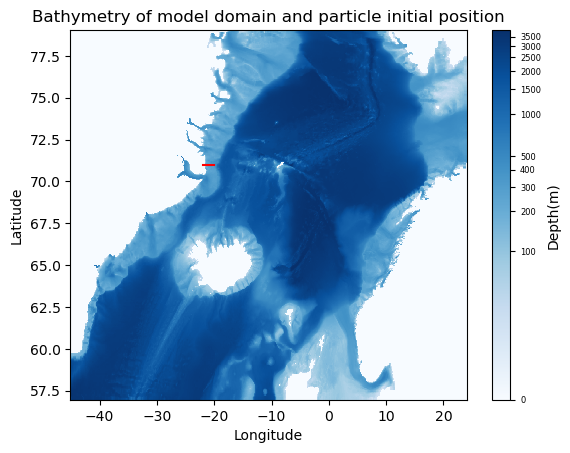

In [8]:
plt.pcolormesh(ds["XC"], ds["YC"], np.log10(ds["Depth"] + 10), cmap="Blues")
plt.plot(x, y, "r")
cb = plt.colorbar(label="Depth(m)")
cbar_depth = np.concatenate([np.arange(0, 500, 100), np.arange(500, 4000, 500)])
cb.ax.set_yticks(np.log10(cbar_depth + 10), cbar_depth, fontsize=6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bathymetry of model domain and particle initial position")
plt.show()

**Fig.1** The initial position of the particles released (red line) on a horizontal map of the surrounding regions.

We are going to follow a cold puff of fresh water near the Greenland shelf. Since we have `OceanSpy` installed here at SciServer, let me quickly show you how to make a vertical section of this region. (It really takes no effort at all!)

Cutting out the oceandataset.
Carrying out survey.
Variables to interpolate: ['XC', 'YC', 'XG', 'YG', 'dxC', 'dyC', 'dxF', 'dyF', 'dxG', 'dyG', 'dxV', 'dyU', 'rA', 'rAw', 'rAs', 'rAz', 'fCori', 'fCoriG', 'R_low', 'Ro_surf', 'Depth', 'HFacC', 'HFacW', 'HFacS', 'oceQsw_AVG', 'TFLUX', 'SFLUX', 'oceFWflx_AVG', 'UVELMASS', 'VVELMASS', 'WVELMASS', 'ADVr_TH', 'ADVx_TH', 'ADVy_TH', 'DFrI_TH', 'ADVr_SLT', 'ADVx_SLT', 'ADVy_SLT', 'DFrI_SLT', 'KPPg_TH', 'KPPg_SLT', 'oceSPtnd', 'U', 'V', 'Temp', 'S', 'Eta', 'W', 'MXLDEPTH', 'oceTAUX', 'oceTAUY', 'oceFWflx', 'oceSflux', 'oceQnet', 'oceQsw', 'oceFreez', 'TRELAX', 'SRELAX', 'surForcT', 'surForcS', 'TFLUX_SNAP', 'SFLUX_SNAP', 'botTauX', 'botTauY', 'EXFhs', 'EXFhl', 'EXFlwnet', 'EXFswnet', 'EXFlwdn', 'EXFswdn', 'EXFqnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFatemp', 'EXFaqh', 'EXFevap', 'EXFpreci', 'EXFsnow', 'EXFempmr', 'EXFpress', 'EXFsalfx', 'SIarea', 'SIheff', 'SIhsnow', 'SIhsalt', 'SItices', 'SIuice', 'SIvice', 'SItaux', 'SItauy', 'SI

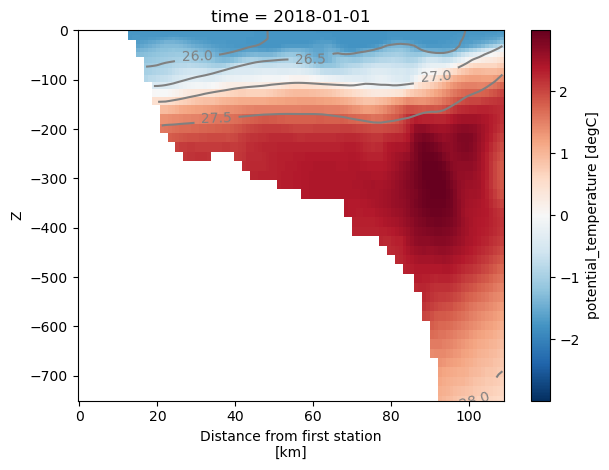

In [9]:
od_surv = od.subsample.survey_stations(
    Xsurv=[-22.0, -19.0], Ysurv=[71.0, 71.0], delta=1
)
od_surv._ds = od_surv._ds.isel(time=0)
od_surv.plot.vertical_section(varName="Temp", contourName="Sigma0")
plt.ylim([-750, 0])
plt.show()

**Fig.2** Vertical section at 71N. This vertical section goes a little further east than the initial particle positions to include the shelf break. Colors denotes the potential temperature, while the contours are the potential density anomaly calculated using OceanSpy (with the equation of state the model used).

Since we are in an open domain (in all three dimensions), given long enough time, some particles will leave the domain. This will jeopardise the entire simulation!  We can define a callback function to stop that from happening.

If provided, the function will be called every time particles cross walls. It can be used to manipulate the particles and catch the out-of-domain issue. But here we just use it as a stop/continue criterion.

In [10]:
def continue_criterion(pt):
    x_ = np.logical_and(pt.lon < -10, pt.lon > -35)
    y_ = np.logical_and(pt.lat < 72, pt.lat > 65)
    z_ = pt.dep > -750
    return np.logical_and(np.logical_and(x_, y_), z_)

This time we are going to use volume flux (transport) to advect the particles. This is usually better than using the velocity field itself.

In [11]:
oce["utrans"] = oce["U"] * oce["drF"] * oce["dyG"]
oce["vtrans"] = oce["V"] * oce["drF"] * oce["dxG"]
oce["wtrans"] = oce["W"] * oce["rA"]

Finally, create the particle object:

In [12]:
p = sd.Particle(
    x=x,
    y=y,
    z=z,
    t=t,
    data=oce,
    callback=continue_criterion,
    uname="utrans",
    vname="vtrans",
    wname="wtrans",
    # save_raw = True,
    transport=True,
)

## Perform the particle trajectory simulation

Run the simulation!

In [ ]:
stops, raw = p.to_list_of_time([t[0], tf])

Retrieve the particle positions from the `seaduck.eulerian.position` objects.

In [ ]:
lons = np.array([pt.lon for pt in raw])
lats = np.array([pt.lat for pt in raw])

### Plot results

In [ ]:
plt.pcolormesh(od._ds["XC"], od._ds["YC"], np.log10(od._ds["Depth"] + 10), cmap="Blues")
plt.plot(x, y, "r")
plt.plot(lons, lats, "gold", lw=0.5)
plt.xlim([-35, -10])
plt.ylim([65, 72])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Particle trajectories overlaid on bathymetry map")
plt.show()

**Fig.3** The particle trajectories overlaid on **Fig.1**. The color scheme for bathymetry is the same as **Fig.1**.